# Coronavirus/COVID-19 Timseries Forecasting

- ~~[GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)~~
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

> **~~NOTE: DATA ACQUISITION IS BEING RE-WORKED IN "Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipnynb"~~** -08/12/21

In [1]:
## Fetch new data (if True (long process - ~2 mins)
RUN_FULL_WORKFLOW=True

In [2]:
import sys
'google' in sys.modules

True

In [3]:
# del sys.modules['google']
'google' in sys.modules

True

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coronavirus/COVID-19-Timseries-Forecasting" data-toc-modified-id="Coronavirus/COVID-19-Timseries-Forecasting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coronavirus/COVID-19 Timseries Forecasting</a></span></li><li><span><a href="#Business-Problem" data-toc-modified-id="Business-Problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Business Problem</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Methodology</a></span></li></ul></li></ul></li><li><span><a href="#OBTAIN" data-toc-modified-id="OBTAIN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OBTAIN</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Project-Control-Booleans" data-toc-modified-id="Project-Control-Booleans-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Project Control Booleans</a></span></li></ul></li></ul></li><li><span><a href="#[To-Be-Updated]-COPIED-legacy-book-2-on--09/06/21" data-toc-modified-id="[To-Be-Updated]-COPIED-legacy-book-2-on--09/06/21-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>[To Be Updated] COPIED legacy book 2 on  09/06/21</a></span></li><li><span><a href="#EDA---Comparing-States" data-toc-modified-id="EDA---Comparing-States-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA - Comparing States</a></span><ul class="toc-item"><li><span><a href="#FL" data-toc-modified-id="FL-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FL</a></span><ul class="toc-item"><li><span><a href="#Calc-Delta-Cases/Deaths" data-toc-modified-id="Calc-Delta-Cases/Deaths-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Calc Delta Cases/Deaths</a></span></li></ul></li></ul></li><li><span><a href="#Time-Series-Modeling" data-toc-modified-id="Time-Series-Modeling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Time Series Modeling</a></span><ul class="toc-item"><li><span><a href="#MD" data-toc-modified-id="MD-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>MD</a></span><ul class="toc-item"><li><span><a href="#MD---Cases-New" data-toc-modified-id="MD---Cases-New-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>MD - Cases-New</a></span></li><li><span><a href="#MD---Hospitalized-Currently" data-toc-modified-id="MD---Hospitalized-Currently-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>MD - Hospitalized Currently</a></span></li></ul></li><li><span><a href="#🚨-BOOKMARK:-Data-Quality-Issue---Deaths" data-toc-modified-id="🚨-BOOKMARK:-Data-Quality-Issue---Deaths-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>🚨 BOOKMARK: Data Quality Issue - Deaths</a></span><ul class="toc-item"><li><span><a href="#MD---Deaths-New" data-toc-modified-id="MD---Deaths-New-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>MD - Deaths-New</a></span></li></ul></li></ul></li><li><span><a href="#Function-For-Any-Given-State/-Column" data-toc-modified-id="Function-For-Any-Given-State/-Column-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Function For Any Given State/ Column</a></span><ul class="toc-item"><li><span><a href="#✔-TO-DO:-make-remove_outliers-into-a-helper-function" data-toc-modified-id="✔-TO-DO:-make-remove_outliers-into-a-helper-function-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span><strong>✔ TO DO: make remove_outliers into a helper function</strong></a></span></li></ul></li><li><span><a href="#09/09/21-TO-DO:-update-project_functions-with-new-make_time_series_model" data-toc-modified-id="09/09/21-TO-DO:-update-project_functions-with-new-make_time_series_model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><strong>09/09/21 TO DO: update project_functions with new <code>make_time_series_model</code></strong></a></span></li><li><span><a href="#@interact" data-toc-modified-id="@interact-9"><span class="toc-item-num">9&nbsp;&nbsp;</span><code>@interact</code></a></span></li><li><span><a href="#APPENDIX" data-toc-modified-id="APPENDIX-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>APPENDIX</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#def-modeling-functions" data-toc-modified-id="def-modeling-functions-10.0.1"><span class="toc-item-num">10.0.1&nbsp;&nbsp;</span><code>def</code> modeling functions</a></span></li></ul></li></ul></li></ul></div>

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

- See `data_acquisition.py`> `FULL_WORKFLOW()` and `1_Replacing Covid Tracking Project - Simplified Workflow.ipynb` for details (for now)


# OBTAIN

## Imports

In [4]:
# !pip install -U pmdarima
!pip install -U fsds

In [5]:
from fsds.imports import *

fsds v0.4.4 loaded.


Package,Handle,Version,Documentation,Imported
pandas,pd,1.1.3,https://pandas.pydata.org/docs/,Y
fsds,fs,0.4.4,https://fs-ds.readthedocs.io/en/latest/,Y
numpy,np,1.19.2,https://numpy.org/doc/stable/reference/,Y
matplotlib,mpl,3.3.1,https://matplotlib.org/stable/api/index.html,Y
matplotlib.pyplot,plt,,https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot,Y
seaborn,sns,0.11.0,https://seaborn.pydata.org/api.html,Y
IPython.display,dp,,https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html,Y
sklearn,,0.23.2,,N


In [6]:
import os,glob,sys,joblib,zipfile,json
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)
# fs.check_package_versions(['statsmodels'],fpath=True)

In [7]:
### FORECAST SPECIFIC FUNCTIONS
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

fs.check_package_versions(['statsmodels','pmdarima'],fpath=False)

,Package,Version
0,statsmodels,0.12.2
1,pmdarima,1.8.2


In [8]:
df = fs.datasets.load_hotel_bookings()
df#.style

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [9]:
import statsmodels
print(f"Statsmodels version: {statsmodels.__version__}")

import pmdarima
print(f"pmdarima version: {pmdarima.__version__}")

Statsmodels version: 0.12.2
pmdarima version: 1.8.2


In [10]:
## Custom Functions and Classes
%load_ext autoreload
%autoreload 2
# import project_functions as fn
import fsds.pandemic as fn

## Data

In [11]:
## Using new savedd FILE_DIRECTORIES
import os,json,glob

with open("FILE_DIRECTORY.json") as f:
    FPATHS = json.load(f)
FPATHS

{'fpath_raw': './data_raw/',
 'fpath_clean': './data/',
 'fpath_reference': './reference_data/',
 'fpath_state_data': './data/state_data/',
 'fpath_final_states': './data/FINAL_STATES.joblib',
 'fpath_final_df_csv': './data/FINAL_STATES.csv.gz',
 'fpath_final_df_pickle': './data/FINAL_STATES.pickle',
 'name_of_fpath_vars': ['fpath_raw',
  'fpath_clean',
  'fpath_reference',
  'fpath_state_data',
  'fpath_final_states',
  'fpath_final_df_csv',
  'fpath_final_df_pickle',
  'name_of_fpath_vars']}

In [12]:
for path_name,fpath in FPATHS.items():
    try:
        
        found_files =  sorted(os.listdir(fpath))
        print(f"\n[i] Files stored in {path_name}:")
        [print("\t",i,x) for i,x in enumerate(found_files)]
    except:
        pass



[i] Files stored in fpath_raw:
	 0 CONVENIENT_us_metadata.csv
	 1 RAW_us_confirmed_cases.csv
	 2 RAW_us_deaths.csv
	 3 covid19-data-from-john-hopkins-university.zip
	 4 hospital_data.csv

[i] Files stored in fpath_clean:
	 0 COLUMNS.joblib
	 1 FINAL_STATES.csv.gz
	 2 FINAL_STATES.joblib
	 3 FINAL_STATES.pickle
	 4 STATE_DICT.joblib
	 5 combined_us_states_full_data.csv
	 6 us_states_cases_deaths.csv
	 7 us_states_daily_cases_deaths.csv

[i] Files stored in fpath_reference:
	 0 COLUMNS.joblib
	 1 population-by-country-2020.zip
	 2 state_codes_to_names_map.joblib
	 3 state_names_to_codes_map.joblib
	 4 united_states_abbreviations.csv
	 5 us_metadata_counties.csv
	 6 us_metadata_states.csv


### Project Control Booleans

In [13]:
RUN_FULL_WORKFLOW=True

In [14]:
# ## making mapper dict to rename new columns
# new_to_match_old_map = {
#     'Deaths':'death',
#     'Cases':'positive',
#     'total_adult_patients_hospitalized_confirmed_covid':'hospitalizedCurrently',
# 'adult_icu_bed_covid_utilization_numerator':'inIcuCurrently'}
# ## making mapper dict to rename new columns
# new_to_final_names = {
#     'Deaths':'Deaths',
#     'Cases':'Cases',
#     'total_adult_patients_hospitalized_confirmed_covid':'Hospitalized Currently',
# 'adult_icu_bed_covid_utilization_numerator':'ICU-Covid Currently'}
# list(new_to_final_names.keys())

In [15]:
FPATHS

{'fpath_raw': './data_raw/',
 'fpath_clean': './data/',
 'fpath_reference': './reference_data/',
 'fpath_state_data': './data/state_data/',
 'fpath_final_states': './data/FINAL_STATES.joblib',
 'fpath_final_df_csv': './data/FINAL_STATES.csv.gz',
 'fpath_final_df_pickle': './data/FINAL_STATES.pickle',
 'name_of_fpath_vars': ['fpath_raw',
  'fpath_clean',
  'fpath_reference',
  'fpath_state_data',
  'fpath_final_states',
  'fpath_final_df_csv',
  'fpath_final_df_pickle',
  'name_of_fpath_vars']}

In [16]:
os.listdir(FPATHS['fpath_clean'])

['COLUMNS.joblib',
 'combined_us_states_full_data.csv',
 'FINAL_STATES.csv.gz',
 'FINAL_STATES.joblib',
 'FINAL_STATES.pickle',
 'STATE_DICT.joblib',
 'us_states_cases_deaths.csv',
 'us_states_daily_cases_deaths.csv']

In [17]:
## Uncomment Cell to acquire new data
if RUN_FULL_WORKFLOW:
    df_states,STATES = fn.data_acquisition.FULL_WORKFLOW(merge_hospital_data=True)
    ## renaming since merge_hofspital_data=True
#     DF = df_states.copy()
#     print(STATES.keys())    
    
else:
    print(f"[i] Using previously downloaded data...")
    df_states = pd.read_pickle(FPATHS['fpath_final_df_pickle'])
    
#     with open(FPATHS['fpath_final_states']) as f:
    STATES = joblib.load(FPATHS['fpath_final_states'])
#     df_states = pd.read_csv(os.path.join(fpath_clean,
#                                          'combined_us_states_full_data.csv'))
#     STATES = joblib.load(os.path.join(fpath_clean,'STATE_DICT.joblib'))

display(df_states.head())
print(STATES.keys())

========= RUNNING FULL WORKFLOW =========
[i] Retrieving kaggle dataset: antgoldbloom/covid19-data-from-john-hopkins-university
- Loading data from RAW_us_confirmed_cases.csv
- Loading data from RAW_us_deaths.csv
[i] Retrieving hospital data from https://healthdata.gov/resource/g62h-syeh.csv
[i] Workflow completed.
	Run time=0:00:54.471118 sec.
[i]The final files of note:
	./data/combined_us_states_full_data.csv
	./data/STATE_DICT.joblib
[i] Final joined data (DF) saved as ./data/FINAL_STATES.csv.gz
[i] Final joined data (DF) saved as ./data/FINAL_STATES.pickle


Deaths  Cases  ...  Deaths-New  Cases-New
   Date                       ...                       
AK 2020-03-23       0     39  ...         0.0        0.0
   2020-03-24       0     43  ...         0.0        4.0
   2020-03-25       1     50  ...         1.0        7.0
   2020-03-26       1     64  ...         0.0       14.0
   2020-03-27       1     75  ...         0.0       11.0

[5 rows x 6 columns]

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])


# [To Be Updated] COPIED legacy book 2 on  09/06/21

# EDA - Comparing States

## FL

In [18]:
FL = STATES['FL'].copy()
FL

,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-03-12,2,30,0.0,0.0,0.0,0.0
2020-03-13,2,50,0.0,0.0,0.0,20.0
2020-03-14,2,76,0.0,0.0,0.0,26.0
2020-03-15,3,100,0.0,0.0,1.0,24.0
2020-03-16,3,101,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2021-09-04,46324,3352451,13228.0,3160.0,0.0,0.0
2021-09-05,46324,3352451,13172.0,3139.0,0.0,0.0
2021-09-06,46324,3352451,13136.0,3115.0,0.0,0.0


In [19]:
## first non-null hospital timestamps
first_ts = FL[FL['Hospitalized Currently'].notna()].index[0]
first_ts

Timestamp('2020-03-12 00:00:00')

### Calc Delta Cases/Deaths

In [20]:
FL.columns

Index(['Deaths', 'Cases', 'Hospitalized Currently', 'ICU-Covid Currently',
       'Deaths-New', 'Cases-New'],
      dtype='object')

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

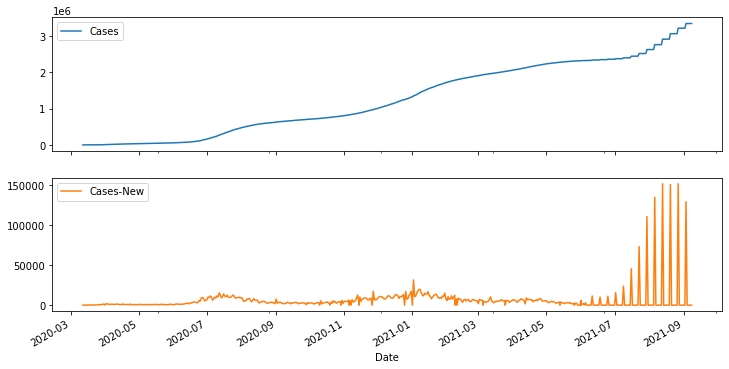

In [21]:
## Plot deaths/cases
cumulative_cols = [c for c in FL.columns for name in ['Daths','Cases']if name in c]
FL[cumulative_cols].plot(subplots=True)

In [22]:
import plotly
plotly.__version__

'5.3.1'

<AxesSubplot:>

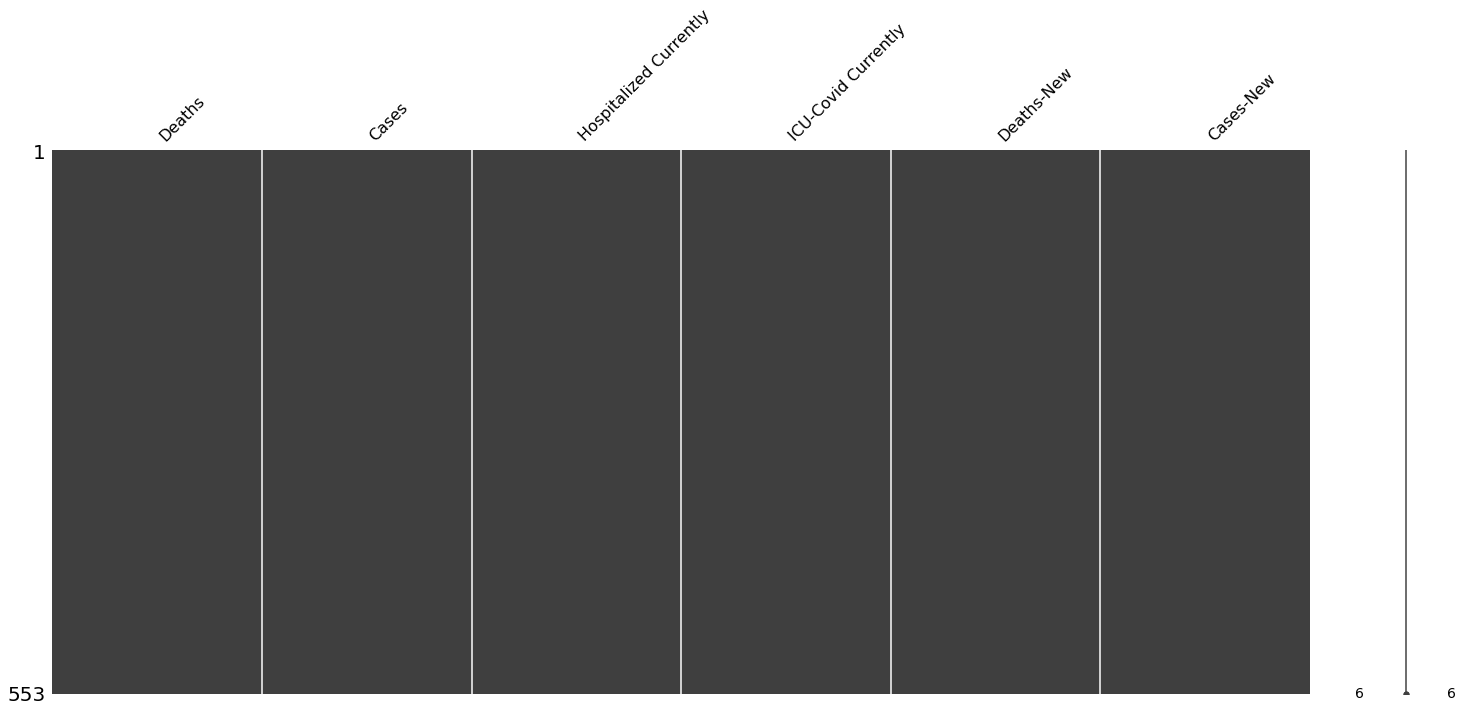

In [23]:
import missingno
missingno.matrix(FL)

In [24]:
# px.imshow(FL.isna(),template='plotly_dark',color_continuous_scale="Reds")

In [25]:
plot_cols = FL.drop(columns=cumulative_cols).columns
plot_cols

Index(['Deaths', 'Hospitalized Currently', 'ICU-Covid Currently',
       'Deaths-New'],
      dtype='object')

In [26]:
import plotly 
plotly.__version__

'5.3.1'

In [27]:
pfig = px.line(FL,y=plot_cols,width=1000,title="FL Data")
pfig.add_vline(first_ts,line_width=3,line_dash="dash",name='Start')
pfig.show()

In [28]:
# raise Exception('end of 09/01/21, though below code is still good.')

# Time Series Modeling

In [29]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

## MD

In [30]:
state = "MD"
df_state = STATES[state].loc['08-2020':].copy()
# df_state = df_state.interpolate('time')
# df_state['Deaths-New'] = df_state['Deaths'].diff()
# df_state['Cases-New'] = df_state['Cases'].diff()
df_state = df_state.resample('D').sum()

print(df_state.isna().sum())
df_state

Deaths                    0
Cases                     0
Hospitalized Currently    0
ICU-Covid Currently       0
Deaths-New                0
Cases-New                 0
dtype: int64


,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-08-01,3506,89365,629.0,171.0,13.0,1019.0
2020-08-02,3515,90274,606.0,180.0,9.0,909.0
2020-08-03,3523,91144,574.0,176.0,8.0,870.0
2020-08-04,3530,91854,576.0,191.0,7.0,710.0
2020-08-05,3536,92426,571.0,186.0,6.0,572.0
...,...,...,...,...,...,...
2021-09-03,10051,501035,809.0,223.0,11.0,1387.0
2021-09-04,20122,1004458,1638.0,428.0,10.0,1194.0
2021-09-05,10073,503034,797.0,213.0,12.0,805.0


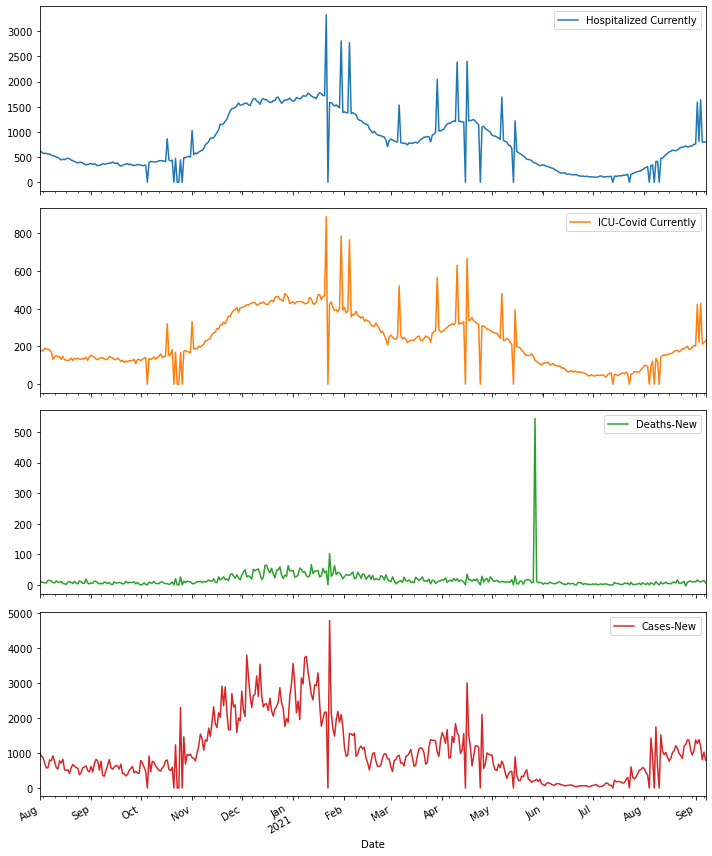

In [31]:
model_cols = ['Hospitalized Currently','ICU-Covid Currently',
              'Deaths-New','Cases-New'
             ]

## visualize
ax = df_state[model_cols].plot(subplots=True, figsize=(10,12))
plt.tight_layout();

#### Data Quality Issues
- There are strong spikes +/- that are not likely to be real values.

### MD - Cases-New

In [32]:
# col = 'Cases-New'
# ts = df_state[col].copy()
# ax = ts.plot(title=f"{state}-{col}");
# ax.set_ylabel(col)

#### Train Test Split

In [33]:
# train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

In [34]:
# ## Get Decomposed time sereis
# decomp = tsa.seasonal_decompose(train)
# decomp.plot();

In [35]:
# ax = decomp.seasonal.loc['01-2021'].plot(figsize=(12,5))
# ax.grid(which='both')

- Seasonality appears to be ~7 days

In [36]:
# fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

In [37]:
# fn.modeling.plot_acf_pacf(train,);

In [38]:
# fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [39]:
# from pmdarima import auto_arima

# auto_model = auto_arima(train,m=7,trace=True,D=1,
#                         start_p=0, start_q=0,
#                         start_P=0, start_Q=0)
# auto_model.summary()

#### Use Best Params for new SARIMAX

In [40]:
# model = tsa.SARIMAX(train, order=auto_model.order, 
#                     seasonal_order =auto_model.seasonal_order,
#                     enforce_invertibility=False,
#                     enforce_stationarity=False, 
#                     freq='D').fit()

# fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

In [41]:
# model = tsa.SARIMAX(ts,order=auto_model.order, 
#                     seasonal_order =auto_model.seasonal_order,
#                     enforce_invertibility=False,
#                     enforce_stationarity=False, 
#                     freq='D').fit()
# fn.modeling.diagnose_model(model)
# fn.modeling.plot_forecast(model, ts)

### MD - Hospitalized Currently

In [42]:
# df_state['Hospitalized Currently']

In [43]:
# col = 'Hospitalized Currently'
# ts = df_state[col].copy()
# ax = ts.plot(title=f"{state}-{col}");
# ax.set_ylabel(col)

#### Train Test Split

In [44]:
# train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

In [45]:
# ## Get Decomposed time sereis
# decomp = tsa.seasonal_decompose(train)
# decomp.plot();

In [46]:
# ax = decomp.seasonal.loc['01-2021'].plot()
# ax.grid(which='both')

- Seasonality appears to be ~7 days

In [47]:
# fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

In [48]:
# fn.modeling.plot_acf_pacf(train,);

In [49]:
# fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [50]:
# from pmdarima import auto_arima

# auto_model = auto_arima(train,m=7,trace=True,D=1,
#                         start_p=0, start_q=0,
#                         start_P=0, start_Q=0)
# auto_model.summary()

#### Use Best Params for new SARIMAX

In [51]:
# model = tsa.SARIMAX(train, order=auto_model.order, 
#                     seasonal_order =auto_model.seasonal_order,
#                     enforce_invertibility=False,
#                     enforce_stationarity=False, 
#                     freq='D').fit()

# fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

In [52]:
# model = tsa.SARIMAX(ts,order=auto_model.order, 
#                     seasonal_order =auto_model.seasonal_order,
#                     enforce_invertibility=False,
#                     enforce_stationarity=False, 
#                     freq='D').fit()
# fn.modeling.diagnose_model(model)
# fn.modeling.plot_forecast(model, ts)

## 🚨 BOOKMARK: Data Quality Issue - Deaths

- To Do: Remove outliers.
    - Try using .diff() and a high threshold for deterining outliers

### MD - Deaths-New

Text(0, 0.5, 'Deaths-New')

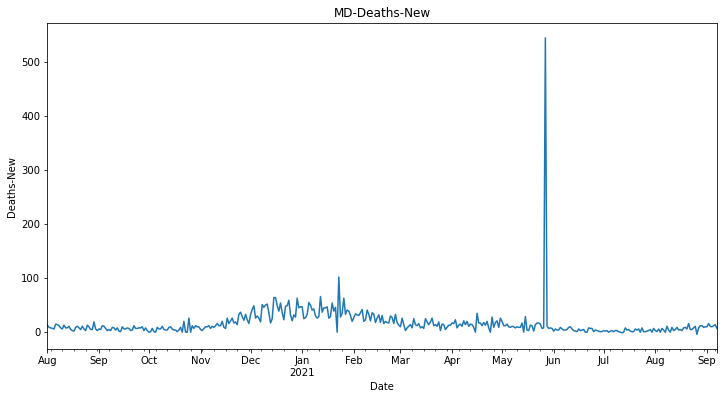

In [53]:
col = 'Deaths-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

In [54]:
## saving deltas 
deltas  = ts.diff()

## SSaving outleirs
threshold=100
outliers = deltas[deltas.abs()>threshold]
outliers

Date
2021-01-23    102.0
2021-05-27    536.0
2021-05-28   -533.0
Name: Deaths-New, dtype: float64

In [55]:
outliers= deltas[deltas.abs()>threshold]
outliers

Date
2021-01-23    102.0
2021-05-27    536.0
2021-05-28   -533.0
Name: Deaths-New, dtype: float64

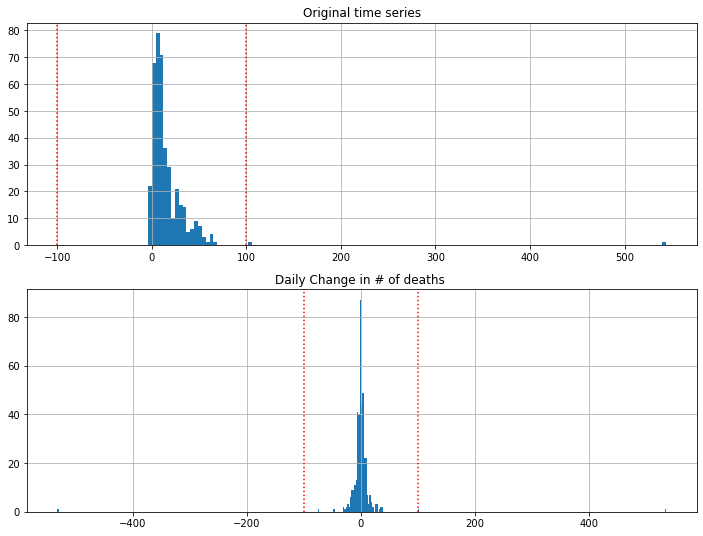

In [56]:
## saving deltas 
fig, axes = plt.subplots(nrows=2,figsize=(12,9))
ax0 = ts.hist(bins='auto',ax=axes[0])
ax0.set(title='Original time series')

## saving deltas 
ax1 = deltas.hist(bins='auto',ax=axes[1])
ax1.set(title='Daily Change in # of deaths ');

for ax in axes:
    ax.axvline(threshold,ls=':',c='red')
    ax.axvline(-threshold,ls=':',c='red')

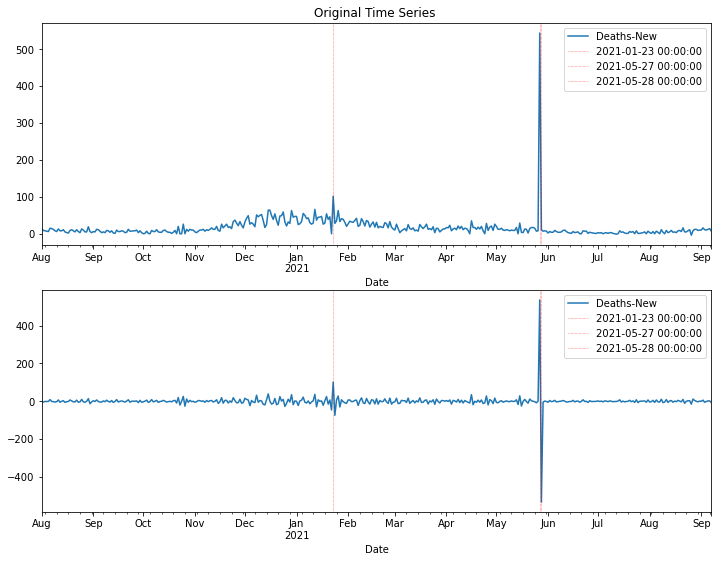

In [57]:
## Plotting High Deltas on original time seires

## saving deltas 
fig, axes = plt.subplots(nrows=2,figsize=(12,9))

ax =axes[0]
ts.plot(ax = ax)
ax.set(title='Original Time Series ')

deltas.plot(ax=axes[1])
for ax in axes:
    [ax.axvline(x_val,label=x_val,lw=0.5,ls = ':',color='red') for x_val in outliers.index]
    ax.legend()



> The issues seem to be entirely in the deltas and therefore 

<AxesSubplot:xlabel='Date'>

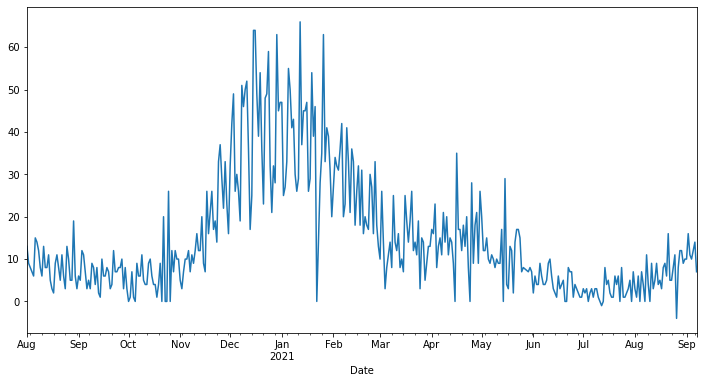

In [58]:
## saving deltas 
deltas  = ts.diff()

## SSaving outleirs
threshold=100
outliers = deltas[deltas.abs()>threshold]


## Filling in outliers
ts.loc[outliers.index] = np.nan
ts.interpolate(inplace=True)
ts.plot()

<AxesSubplot:xlabel='Date'>

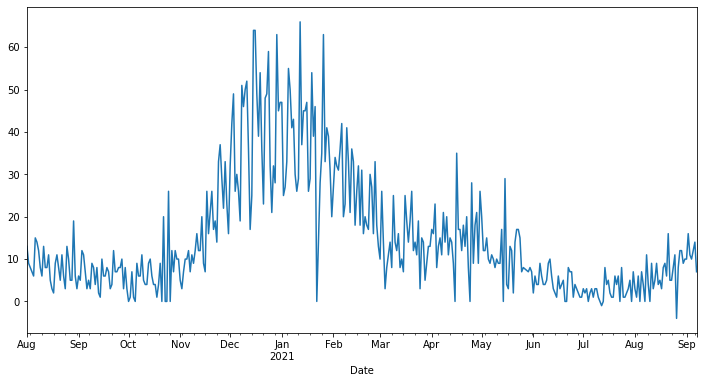

In [59]:

## Filling in outliers
ts.loc[outliers.index] = np.nan
ts.interpolate(inplace=True)
ts.plot()

In [60]:
# raise Exception('Deal with the data quality issue above')

#### Train Test Split

Using a cutoff index of -30, which = 08-09-2021


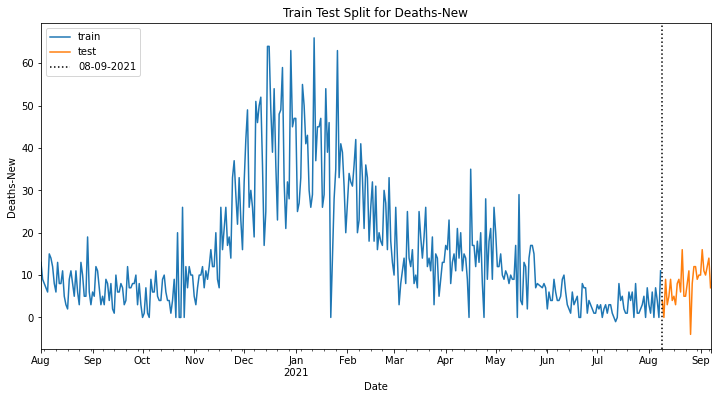

In [61]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

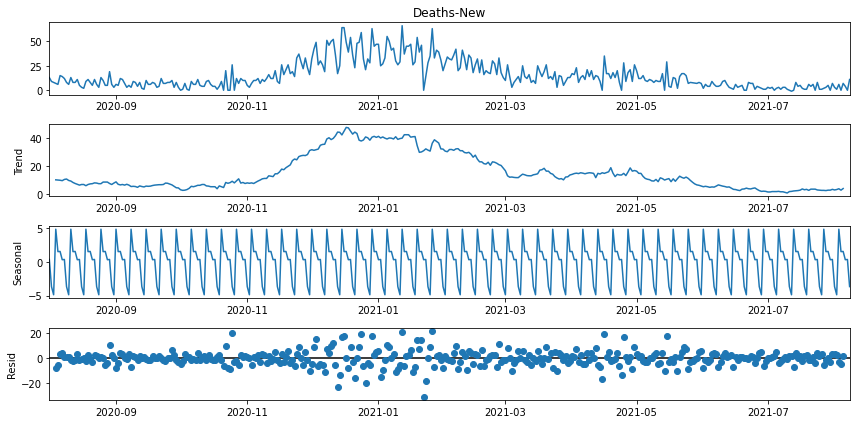

In [62]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

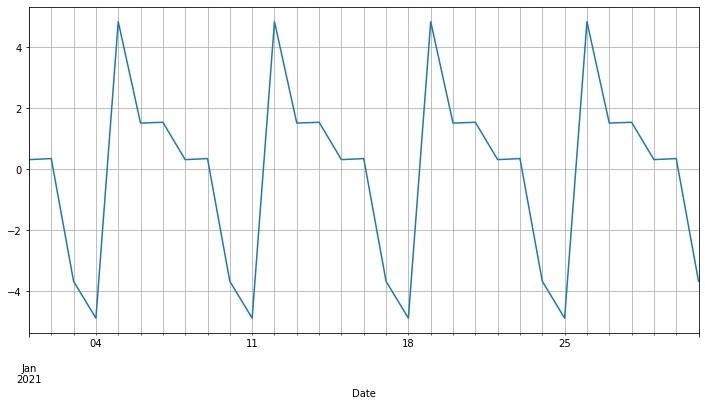

In [63]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.520059,14,351,0.007487,True,True


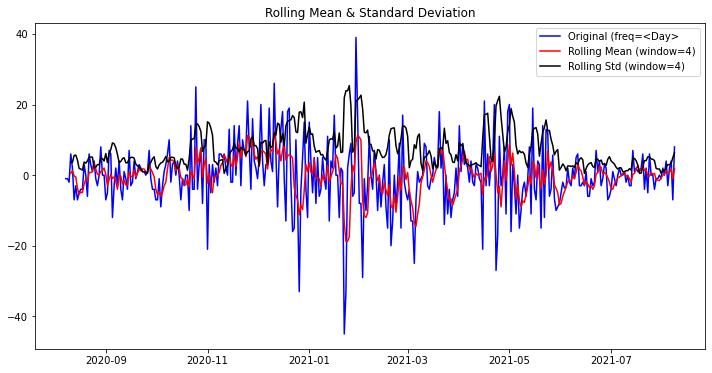

In [64]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

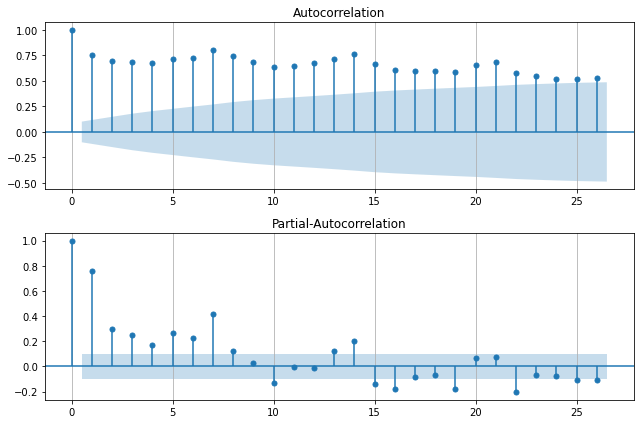

In [65]:
fn.modeling.plot_acf_pacf(train,);

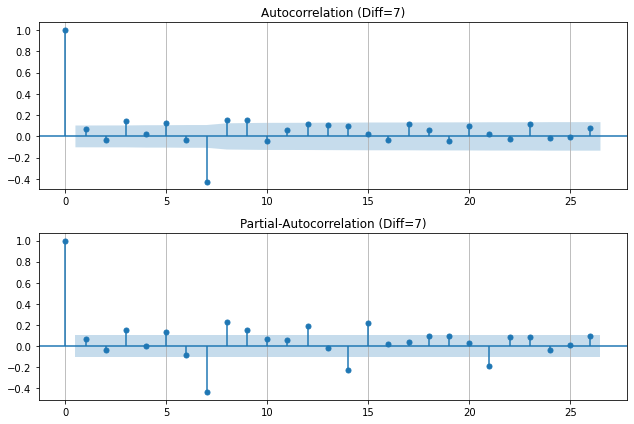

In [66]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [67]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2645.522, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=2567.303, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=2566.468, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=2643.585, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=2645.653, Time=0.12 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=2562.502, Time=0.29 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=2568.481, Time=0.21 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=2563.204, Time=0.75 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=2558.815, Time=0.58 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=2559.898, Time=0.34 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=2560.723, Time=0.90 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=2565.922, Time=0.41 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=2491.117, Time=1.18 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=2489.121, Time=0.78 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  373
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -1238.568
Date:                                Thu, 09 Sep 2021   AIC                           2487.137
Time:                                        21:46:07   BIC                           2506.650
Sample:                                             0   HQIC                          2494.891
                                                - 373                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9822      0.010     95.381      0.000       0.962       1.002
ma.L1         -0.8295      0.029    -28.665      0.000      -0.886      -0.773
ma.S.L7       -0.7951      0.045    -17.637      0.000      -0.883      -0.707
ma.S.L14       0.1004      0.045      2.240      0.025       0.013       0.188
sigma2        50.2334      2.169     23.161      0.000      45.983      54.484
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               269.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.31
Prob(H) (two-sided):                  0.59   Kurtosis:                         7.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                             Deaths-New   No. Observations:                  373
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -1188.989
Date:                                Thu, 09 Sep 2021   AIC                           2387.979
Time:                                        21:46:08   BIC                           2407.268
Sample:                                    08-01-2020   HQIC                          2395.657
                                         - 08-08-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9830      0.011     93.083      0.000       0.962       1.004
ma.L1         -0.8279      0.030    -27.667      0.000      -0.887      -0.769
ma.S.L7       -0.8024      0.047    -17.183      0.000      -0.894      -0.711
ma.S.L14       0.1107      0.046      2.387      0.017       0.020       0.202
sigma2        51.9068      2.319     22.386      0.000      47.362      56.451
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               239.40
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.32
Prob(H) (two-sided):                  0.18   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

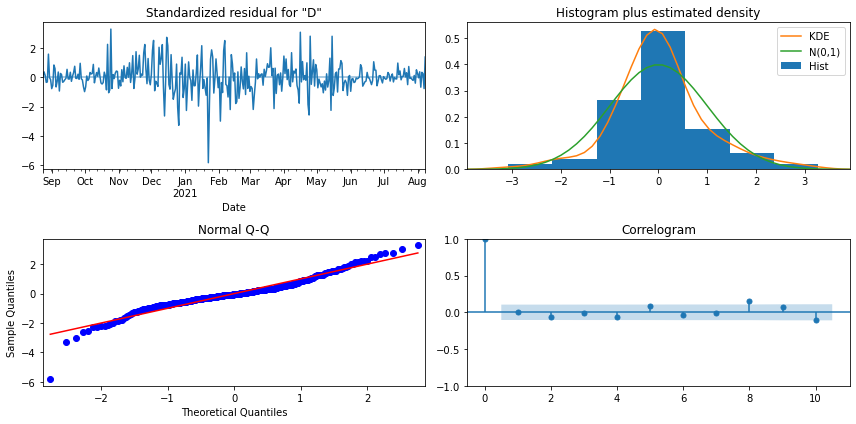

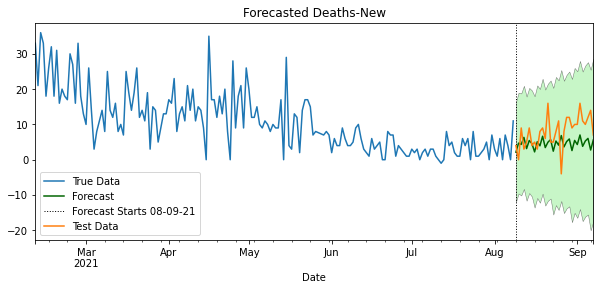

In [68]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                             Deaths-New   No. Observations:                  403
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -1281.019
Date:                                Thu, 09 Sep 2021   AIC                           2572.038
Time:                                        21:46:10   BIC                           2591.739
Sample:                                    08-01-2020   HQIC                          2579.855
                                         - 09-07-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9839      0.010    100.866      0.000       0.965       1.003
ma.L1         -0.8283      0.028    -29.557      0.000      -0.883      -0.773
ma.S.L7       -0.8112      0.044    -18.401      0.000      -0.898      -0.725
ma.S.L14       0.1142      0.044      2.602      0.009       0.028       0.200
sigma2        49.2928      2.081     23.692      0.000      45.215      53.371
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               288.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

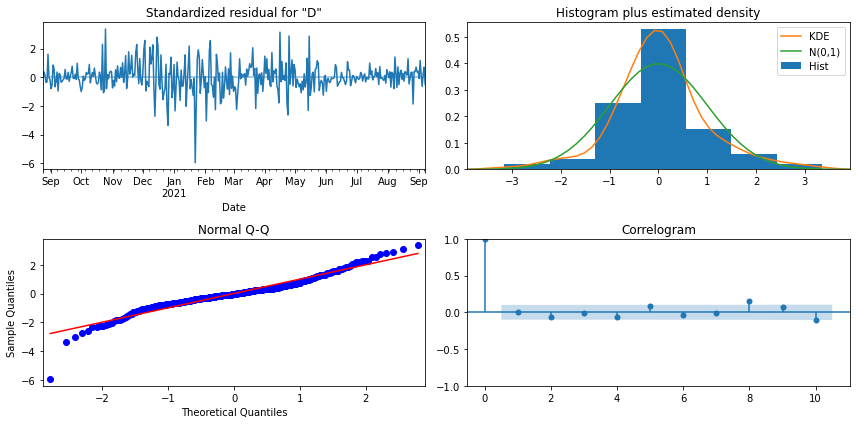

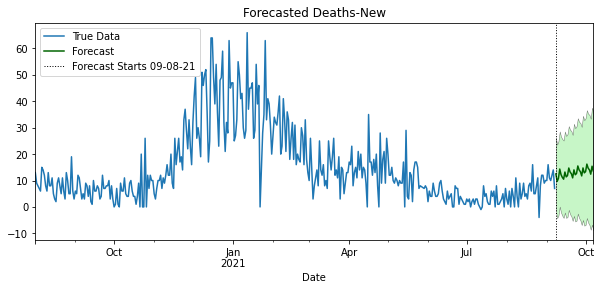

In [69]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

# Function For Any Given State/ Column

In [70]:
# state = "NY"
# col = 'Deaths'#'Hospitalized Currently'
# start_date='08-2020'
# remove_outliers=True
# threshold=100
# plot=True


# df_state = STATES[state].loc[start_date:].copy()
# df_state = df_state.resample('D').sum()
# ts = df_state[col].copy()
# ts.index.name='Datetime'

# # ts = ts.resample('D').asfreq()
# ts

## **✔ TO DO: make remove_outliers into a helper function**

```python
## TO DO: make remove_outliers into a helper function
if remove_outliers:
    ## saving deltas 
    deltas  = ts.diff()

    ## SSaving outleirs
    outliers = deltas[deltas.abs()>threshold]


    ## Filling in outliers
    ts.loc[outliers.index] = np.nan
    ts.interpolate(inplace=True)
```


In [82]:
def remove_outliers_ts(ts,threshold_type='raw',threshold=100, n_diff=1):
    ## saving deltas 
    deltas  = ts.diff(n_diff)
    
    
    ## Criterion
    if threshold_type=='raw':
        idx_outliers = deltas.abs()>threshold
        
#     elif threshold_type :
#         pass
    else:
        raise Exception("threshold_kinds are not yet implemented")
        pass
    ## SSaving outleirs
    outliers = deltas[idx_outliers]


    ## Filling in outliers
    ts.loc[outliers.index] = np.nan
    ts_out = ts.interpolate()
    
    return ts_out
     
    


<AxesSubplot:xlabel='Date'>

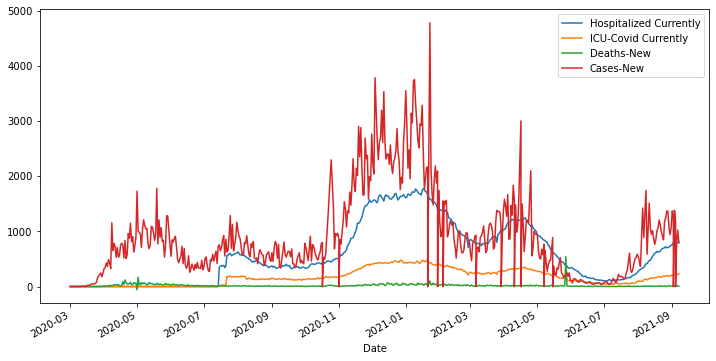

In [83]:
## test function
ts = STATES['MD'].copy()
ts.drop(['Deaths','Cases'],1).plot()

In [112]:
ts['Cases-New'].diff().plot()

KeyError: 'Cases-New'

# **09/09/21 TO DO: update project_functions with new `make_time_series_model`**

In [151]:
def make_timeseries_model(STATES,state = "MD",col = 'Cases-New',
                          start_date='08-2020',split_index=-30,
                         remove_outliers=True,threshold=100,
                         plot=True):
    
    eq = ' '+'==='*40
    
    auto_arima_params = dict(m=7,trace=True,D=1,
                            start_p=0, start_q=0,
                            start_P=0, start_Q=0)
    print(eq,f"\n\tStarting pdmdarima arma grid search for {state} - {col}\n".upper(),
          eq,"\n\t\t{")
    [print(f"\t\t{k} : {v}") for k,v in auto_arima_params.items()]
    print("\t}")
    

    ## Slicing out state df for index dates 
    df_state = STATES[state].loc[start_date:].copy()
    df_state = df_state.resample('D').sum()
    ts = df_state[col].copy()

    ## Outlier removal 
    if remove_outliers:
        ## saving deltas 
        deltas  = ts.diff()

        ## SSaving outleirs
        outliers = deltas[deltas.abs()>threshold]


        ## Filling in outliers
        ts.loc[outliers.index] = np.nan
        ts.interpolate(inplace=True)
    
#     if plot:
#         ax = ts.plot(title=f"{state} - {col}");
#         ax.set_ylabel(col)
#         display(ax.get_figure())
        
        

    from pmdarima import auto_arima
    train,test = fn.modeling.train_test_split_ts(ts,split_index=split_index)
    
    ## update axis/labels
    ax = plt.gca()
    ax.set(title=f"{state} - {col}",ylabel=col);
    plt.show()
        
        
    

    auto_model = auto_arima(train,**auto_arima_params)
    display(auto_model.summary())
        
    model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

    fn.modeling.evaluate_model(model,train,test,last_n_lags=180)
    
    
    model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
    fn.modeling.diagnose_model(model)
    fn.modeling.plot_forecast(model, ts)
    
    return ts, model
    

	STARTING PDMDARIMA ARMA GRID SEARCH FOR NY - HOSPITALIZED CURRENTLY
		{
		m : 7
		trace : True
		D : 1
		start_p : 0
		start_q : 0
		start_P : 0
		start_Q : 0
	}
Using a cutoff index of -30, which = 08-10-2021


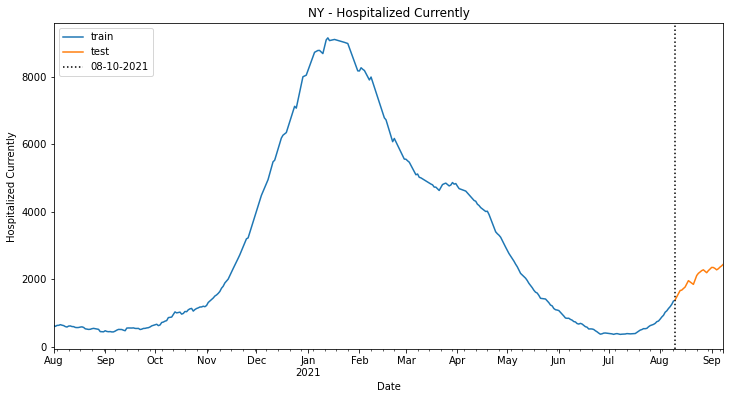

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=4021.222, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=3900.531, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=3907.253, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=3991.519, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=3884.521, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=3871.576, Time=0.51 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=3870.700, Time=0.28 sec


In [ ]:
ts,model = make_timeseries_model(STATES,'NY','Hospitalized Currently')

In [133]:
# STATES['NY']

# `@interact`

In [88]:
from ipywidgets import interact
import datetime as dt

@interact
def get_model(state=list(STATES.keys()),
             col=list(STATES['NY'].columns),model=False):
    if model:
        start = dt.datetime.now()
        ts,model = make_timeseries_model(STATES,state,col)
        end = dt.datetime.now()
        print(f'Modeling Process took {end-start} sec.')

interactive(children=(Dropdown(description='state', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', '…

# APPENDIX

In [89]:
# !pip instal streamlit 
# !streamlist run app.py
!code app.py

### `def` modeling functions

In [90]:
# def train_test_split_ts(ts,test_size=0.9,split_index=None):
#     """Uses test size by default, split_index overrides it"""
#     if split_index is not None:
#         tts_cutoff = split_index
#     else:
#         tts_cutoff = round(ts.shape[0]*0.9)
#     fmt = "%m-%d-%Y"
#     cutoff_time = ts.index[tts_cutoff]
#     print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
#       ## Use the tts cutoff to do Train test split and plot
#     train = ts.iloc[:tts_cutoff]
#     test = ts.iloc[tts_cutoff:]

#     ## Plot
#     ax = train.plot(label='train')
#     test.plot(label='test')
#     ax.legend()
#     ax.set(ylabel=ts.name)
#     ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
#     ax.legend()
#     ax.set_title(f"Train Test Split for {ts.name}")
#     return train, test


In [91]:
# ## funtionize diagnosing
# def diagnose_model(model): #keep
#     """Takes a fit statsmodels model and displays the .summary 
#     and plots the built-in plot.diagnostics()"""
#     display(model.summary())
#     model.plot_diagnostics()
#     plt.tight_layout()
    
    
# def get_forecast(model,steps=14): #keep
#     forecast = model.get_forecast(steps=steps)
#     forecast_df = forecast.conf_int()
#     forecast_df['Forecast'] = forecast.predicted_mean
#     forecast_df.columns = ['Lower CI','Upper CI','Forecast']
#     return forecast_df


# def plot_forecast(forecast_df,ts,orig_label='True Data',
#                   forecast_label='Forecast',
#                   forecast_steps=30,
#                   last_n_lags=None,figsize=(10,4)):
#     """Takes a forecast_df from get_df_from_pred and optionally 
#     the training/original time series.
    
#     Plots the original ts, the predicted mean and the 
#     confidence invtervals (using fill between)"""
#     if not isinstance(forecast_df,pd.DataFrame):
#         forecast_df = get_forecast(forecast_df,steps=forecast_steps)
        
#     fig,ax = plt.subplots(figsize=figsize)

#     if last_n_lags is None:
#         last_n_lags = len(ts)
        
#     ts.iloc[-last_n_lags:].plot(label='True Data')

    
#     forecast_df['Forecast'].plot(ax=ax,color='darkgreen',label=forecast_label)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['Lower CI'], 
#                     forecast_df['Upper CI'],
#                     color='lightgreen',alpha=0.5,lw=0.5,edgecolor='k')
#     ax.set(title=f'Forecasted {ts.name}')
#     sep = forecast_df.index[0]
#     ax.axvline(sep,label=f"Forecast Starts {sep.strftime('%m-%d-%y')}",lw=1,ls=':',c='k')
#     ax.legend()

#     return fig,ax

    
# def evaluate_model(model,train,test,steps=None,last_n_lags=None):
#     diagnose_model(model)
    
#     if steps is None:
#         steps=len(test)
        
#     forecast_df = get_forecast(model,steps=len(test))
#     fig, ax = plot_forecast(forecast_df,train,last_n_lags=last_n_lags)
    
#     test.plot(ax=ax,label='Test Data')
#     ax.legend()
#     return fig,ax
           
 
